# 8b - Elastic/Poroelastic interface response (Signals analysis)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from see.keysight import Trace
from see.misc import find_nearest
from see.signal_processing import relative_wavelet_delay

plt.style.use("natael_styles")

## Constants

In [2]:
INTERELECTRODE = 0.25e-2  # m

## Load experimental resampled data

In [3]:
experimental_data = {
    "36": np.load("./data/13_12_2023/resampled_experimental_data.npy", allow_pickle=True).item(),
    "100": np.load("./data/06_12_2023/resampled_experimental_data.npy", allow_pickle=True).item(),
}

interface_offsets = {
    "36": np.load("./data/13_12_2023/interface_offsets.npy", allow_pickle=True).item(),
    "100": np.load("./data/06_12_2023/interface_offsets.npy", allow_pickle=True).item(),
}

source_offsets = {
    "36": np.load("./data/13_12_2023/source_offsets.npy", allow_pickle=True).item(),
    "100": np.load("./data/06_12_2023/source_offsets.npy", allow_pickle=True).item(),
}

## FB picking through cross-correlation

In [77]:
def plot_and_pick_fb_amplitudes(material, sigma_f, **kwargs):
    gain = kwargs.get("gain", 100)
    xlim = kwargs.get("xlim", [0, 300])
    ylim = kwargs.get("ylim", [-10, 10])
    top_bottom_domain_time = kwargs.get("top_bottom_domain_time", [0, 0])
    reference_traces_fb = kwargs.get("reference_traces_fb", {"top": 0, "bottom": 0})
    figsize = kwargs.get("figsize", (17, 6))
    title = kwargs.get("title", f"{material} - {sigma_f}")

    dataset = experimental_data[sigma_f]["traces"][material]
    dataset_metadata = experimental_data[sigma_f]["metadata"]

    plt.figure(figsize=figsize)
    ax = plt.gca()

    ax.xaxis.set_major_locator(plt.MultipleLocator(base=50))
    ax.grid(True, which="both", ls="--")
    ax.set_ylabel("Interface offset (cm)")
    ax.set_xlabel("Time (µs)")
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_title(title)

    top_reference_trace = None
    bottom_reference_trace = None

    for trace_name, trace_amplitude in dataset.items():
        trace = Trace(dataset_metadata["time"], trace_amplitude)
        trace_offset = interface_offsets[sigma_f][trace_name]*1e2

        # Plot data
        x = trace.time*1e6
        y = trace.amplitude*gain+trace_offset        

        ax.plot(x, y, color='k')
        ax.axvline(top_bottom_domain_time[0], color="r", linestyle="--")
        ax.axvline(top_bottom_domain_time[1], color="r", linestyle="--")

        # Estimate E first break
        # 0. Manually pick the first break time for reference traces (the farthest trace from the interface,
        # e.g. trace with biggest interface offset):
        #    - For traces before the interface, the reference trace is v_bottom_1
        #    - For traces after the interface, the reference trace is v_top_32
        # 1. Crop the trace before or after the interface
        # 2. Compute the current trace delay from a reference trace

        if top_reference_trace == None or bottom_reference_trace == None:
            i_top_end = find_nearest(dataset_metadata["time"]*1e6, 135)[1]
            top_reference_trace = Trace(dataset_metadata["time"], dataset["v_top_32"])
            i_top_start = find_nearest(dataset_metadata["time"]*1e6, top_bottom_domain_time[1])[1]
            bottom_reference_trace = Trace(dataset_metadata["time"]*1e6, dataset["v_bottom_1"])
            i_bottom_end = find_nearest(dataset_metadata["time"], top_bottom_domain_time[0])[1]
            i_source_noise_time = find_nearest(dataset_metadata["time"], 10e-6)[1]

        source_offset = source_offsets[sigma_f][trace_name]*1e2
        reference_trace = top_reference_trace if trace_offset > 0 else bottom_reference_trace
        reference_trace_fb = reference_traces_fb["top" if trace_offset > 0 else "bottom"]

        if trace_offset > 0:
            delay = relative_wavelet_delay(w1=trace.amplitude[i_top_start:i_top_end],
                                           w2=reference_trace.amplitude[i_top_start:i_top_end],
                                           dt=trace.dt)
        else:
            delay = relative_wavelet_delay(w1=trace.amplitude[i_source_noise_time:i_bottom_end],
                                           w2=reference_trace.amplitude[i_source_noise_time:i_bottom_end],
                                           dt=trace.dt)
            
        trace_fb = reference_trace_fb+delay*1e6
        ax.scatter(trace_fb, trace_offset, color="r")

    plt.show()

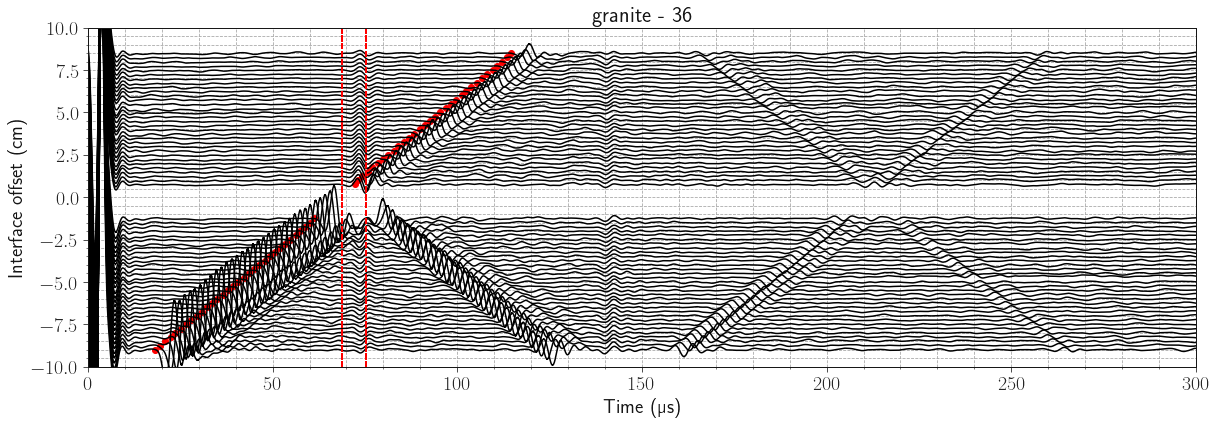

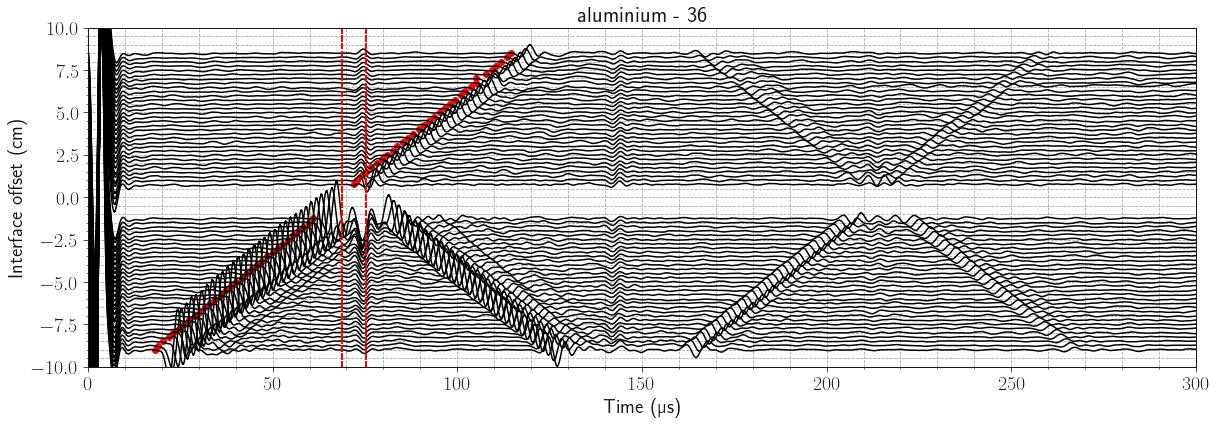

In [79]:
%matplotlib inline
plot_and_pick_fb_amplitudes("granite", "36", gain=1e3, top_bottom_domain_time=[68.7,75.2], reference_traces_fb={"top": 114.5, "bottom": 18.1})

## E and EM amplitudes picking